Loading the datasets

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
emotion=pd.read_csv('/content/emotions.csv')
hate=pd.read_csv('/content/labeled_data.csv')

In [5]:
emotion.head(3)

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4


In [6]:
hate.head(3)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [7]:
emotion['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


In [8]:
hate['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


Data Preprocessing

In [9]:
hate=hate[['tweet','class']]    # keeping only the relevant columns

In [10]:
hate.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [11]:
## Renaming the columns

hate.rename(columns={'tweet':'text','class':'label'},inplace=True)

In [12]:
## Checking for null values

hate.isnull().sum(), emotion.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [13]:
## Checking for duplicated data

hate.duplicated().sum(),emotion.duplicated().sum()

(np.int64(0), np.int64(686))

In [14]:
## Droping the dupe values

emotion.drop_duplicates(inplace=True)

In [15]:
## Extracting the fixed number of rows from the datasets randomly

# for emotion dataset

df1=pd.DataFrame()

for i in range(len(emotion['label'].value_counts().index)):
  subset=emotion[emotion['label']==i].sample(n=2000,random_state=23)
  df1=pd.concat([df1,subset])

In [16]:
df1.shape

(12000, 2)

In [17]:
# for hate dataset



d1=hate[hate['label']==1].sample(n=6407,random_state=23)

d2=hate[hate['label']!=1]

df2=pd.concat([d1,d2])

In [18]:
hate_=df2
emotion_=df1

In [19]:
hate_.reset_index(drop=True,inplace=True)
emotion_.reset_index(drop=True,inplace=True)

emotion_.head()

,text,label
0,i feel i thought i would cry or feel heartbrok...,0
1,i know how it feels to be blamed,0
2,i wanna do but due to my current place i feel ...,0
3,i feel isolated from women of god and women of...,0
4,i feel like im horrible unlovable irredeemable,0


# Text Preprocessing

In [20]:
## Stopword removal

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [21]:
def remove_stopwords(row):
  new_row=[]
  row=word_tokenize(row)
  row=[word.lower() for word in row]
  for word in row:
    if word in stopwords:
      new_row.append('')
    else:
      new_row.append(word)
  return " ".join(new_row)

hate_['text'].apply(remove_stopwords) ,emotion_['text'].apply(remove_stopwords)

(0        @ marshallsots  tryna say  'm  pussy ?  course...
 1        @ themightylayman ``   got ta   red headed afr...
 2                                    lil hoe tweets  point
 3        @ haylgroot ...... bitch & # 128530 ; yeah    ...
 4                                     'm  man-hoe tho ....
                                ...                        
 11995     know   say ,  early bird gets  worm . * puts ...
 11996                                         're  niggers
 11997     're   retard  hope  get type 2 diabetes  die ...
 11998     've gone  broke  wrong heart baby ,  drove  r...
 11999    ~~ruffled | ntac eileen dahlia - beautiful col...
 Name: text, Length: 12000, dtype: object,
 0         feel  thought  would cry  feel heartbroken   ...
 1                                    know   feels   blamed
 2             wan na   due   current place  feel inhibited
 3         feel isolated  women  god  women  power  reme...
 4             feel like im horrible unlovable irredeemab

In [22]:
## applying more text preprocessing

def clean_text(text):
  text=text.lower()
  row=word_tokenize(text)
  row=[word for word in row if word.isalpha()==True]
  return " ".join(row)

hate_['text'].apply(clean_text),emotion_['text'].apply(clean_text)

(0        marshallsots you tryna say i a pussy of course...
 1        themightylayman we just got ta have a red head...
 2                                  lil hoe tweets on point
 3        haylgroot bitch yeah it was me caught me red h...
 4                                                 i no tho
                                ...                        
 11995    you know what they say the early bird gets the...
 11996                                      you all niggers
 11997    you such a retard i hope you get type diabetes...
 11998    you gone and broke the wrong heart baby and dr...
 11999    ntac eileen dahlia beautiful color combination...
 Name: text, Length: 12000, dtype: object,
 0        i feel i thought i would cry or feel heartbrok...
 1                         i know how it feels to be blamed
 2        i wan na do but due to my current place i feel...
 3        i feel isolated from women of god and women of...
 4           i feel like im horrible unlovable irredeemab

Tokenization and padding for the model

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(pd.concat([hate_['text'],emotion_['text']]))


In [25]:
hate_sequences=tokenizer.texts_to_sequences(hate_['text'])
emotion_sequences=tokenizer.texts_to_sequences(emotion_['text'])

In [26]:
emotion_['text'].iloc[2],emotion_sequences[2:3]

('i wanna do but due to my current place i feel inhibited',
 [[1, 295, 49, 24, 1000, 4, 9, 1590, 291, 1, 6, 1432]])

In [27]:
def find_len(row):
  return len(row)

hate_['text'].apply(find_len).max(), emotion_['text'].apply(find_len).max()

(637, 411)

In [28]:
padded_hate=pad_sequences(hate_sequences,maxlen=637,padding='post')
padded_emotion=pad_sequences(emotion_sequences,maxlen=637,padding='post')

## Defining the model architecture

In [29]:
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout
from tensorflow.keras.models import Model, Sequential

In [30]:
## Defining the input layers
emotion_input=Input(shape=(637,),name='Emotion_Input_Layer')
hate_input=Input(shape=(637,),name='Hate_Input_Layer')

## defining the embedding layer
embedding_layer=Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=128)

## Sharing the embedding layer
emotion_embedding=embedding_layer(emotion_input)
hate_embedding=embedding_layer(hate_input)

## Shared LSTM Layer
shared_lstm=LSTM(units=128,return_sequences=True)

## Seperate LSTMs
emotion_lstm=shared_lstm(emotion_embedding)
hate_lstm=shared_lstm(hate_embedding)

## Shared Dropout layer and pooling layer
dropout_layer=Dropout(0.3)
pooling=tf.keras.layers.GlobalAveragePooling1D()

## Individual Dropout layers and pooling layers
dropout_emotion=dropout_layer(pooling(emotion_lstm))
dropout_hate=dropout_layer(pooling(hate_lstm))

## Output layers
output_emotion=Dense(units=6,activation='softmax',name='Emotion_Output_Layer')(dropout_emotion)
output_hate=Dense(units=3,activation='softmax',name='Hate_Output_Layer')(dropout_hate)

# Defining the model
model=Model(inputs=[emotion_input,hate_input],outputs=[output_emotion,output_hate])

# Compiling the model
model.compile(optimizer='adam',
              loss={"Emotion_Output_Layer":'sparse_categorical_crossentropy',"Hate_Output_Layer":"sparse_categorical_crossentropy"},
              metrics={"Emotion_Output_Layer":'accuracy',"Hate_Output_Layer":'accuracy'})

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Emotion_Input_Layer │ (None, 637)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hate_Input_Layer    │ (None, 637)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 637, 128)  │  4,067,968 │ Emotion_Input_La… │
│ (Embedding)         │                   │            │ Hate_Input_Layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 637, 128)  │    131,584 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ lstm[0][0],       │
│ (GlobalAveragePool… │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Emotion_Output_Lay… │ (None, 6)         │        774 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hate_Output_Layer   │ (None, 3)         │        387 │ dropout[1][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,200,713 (16.02 MB)

 Trainable params: 4,200,713 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

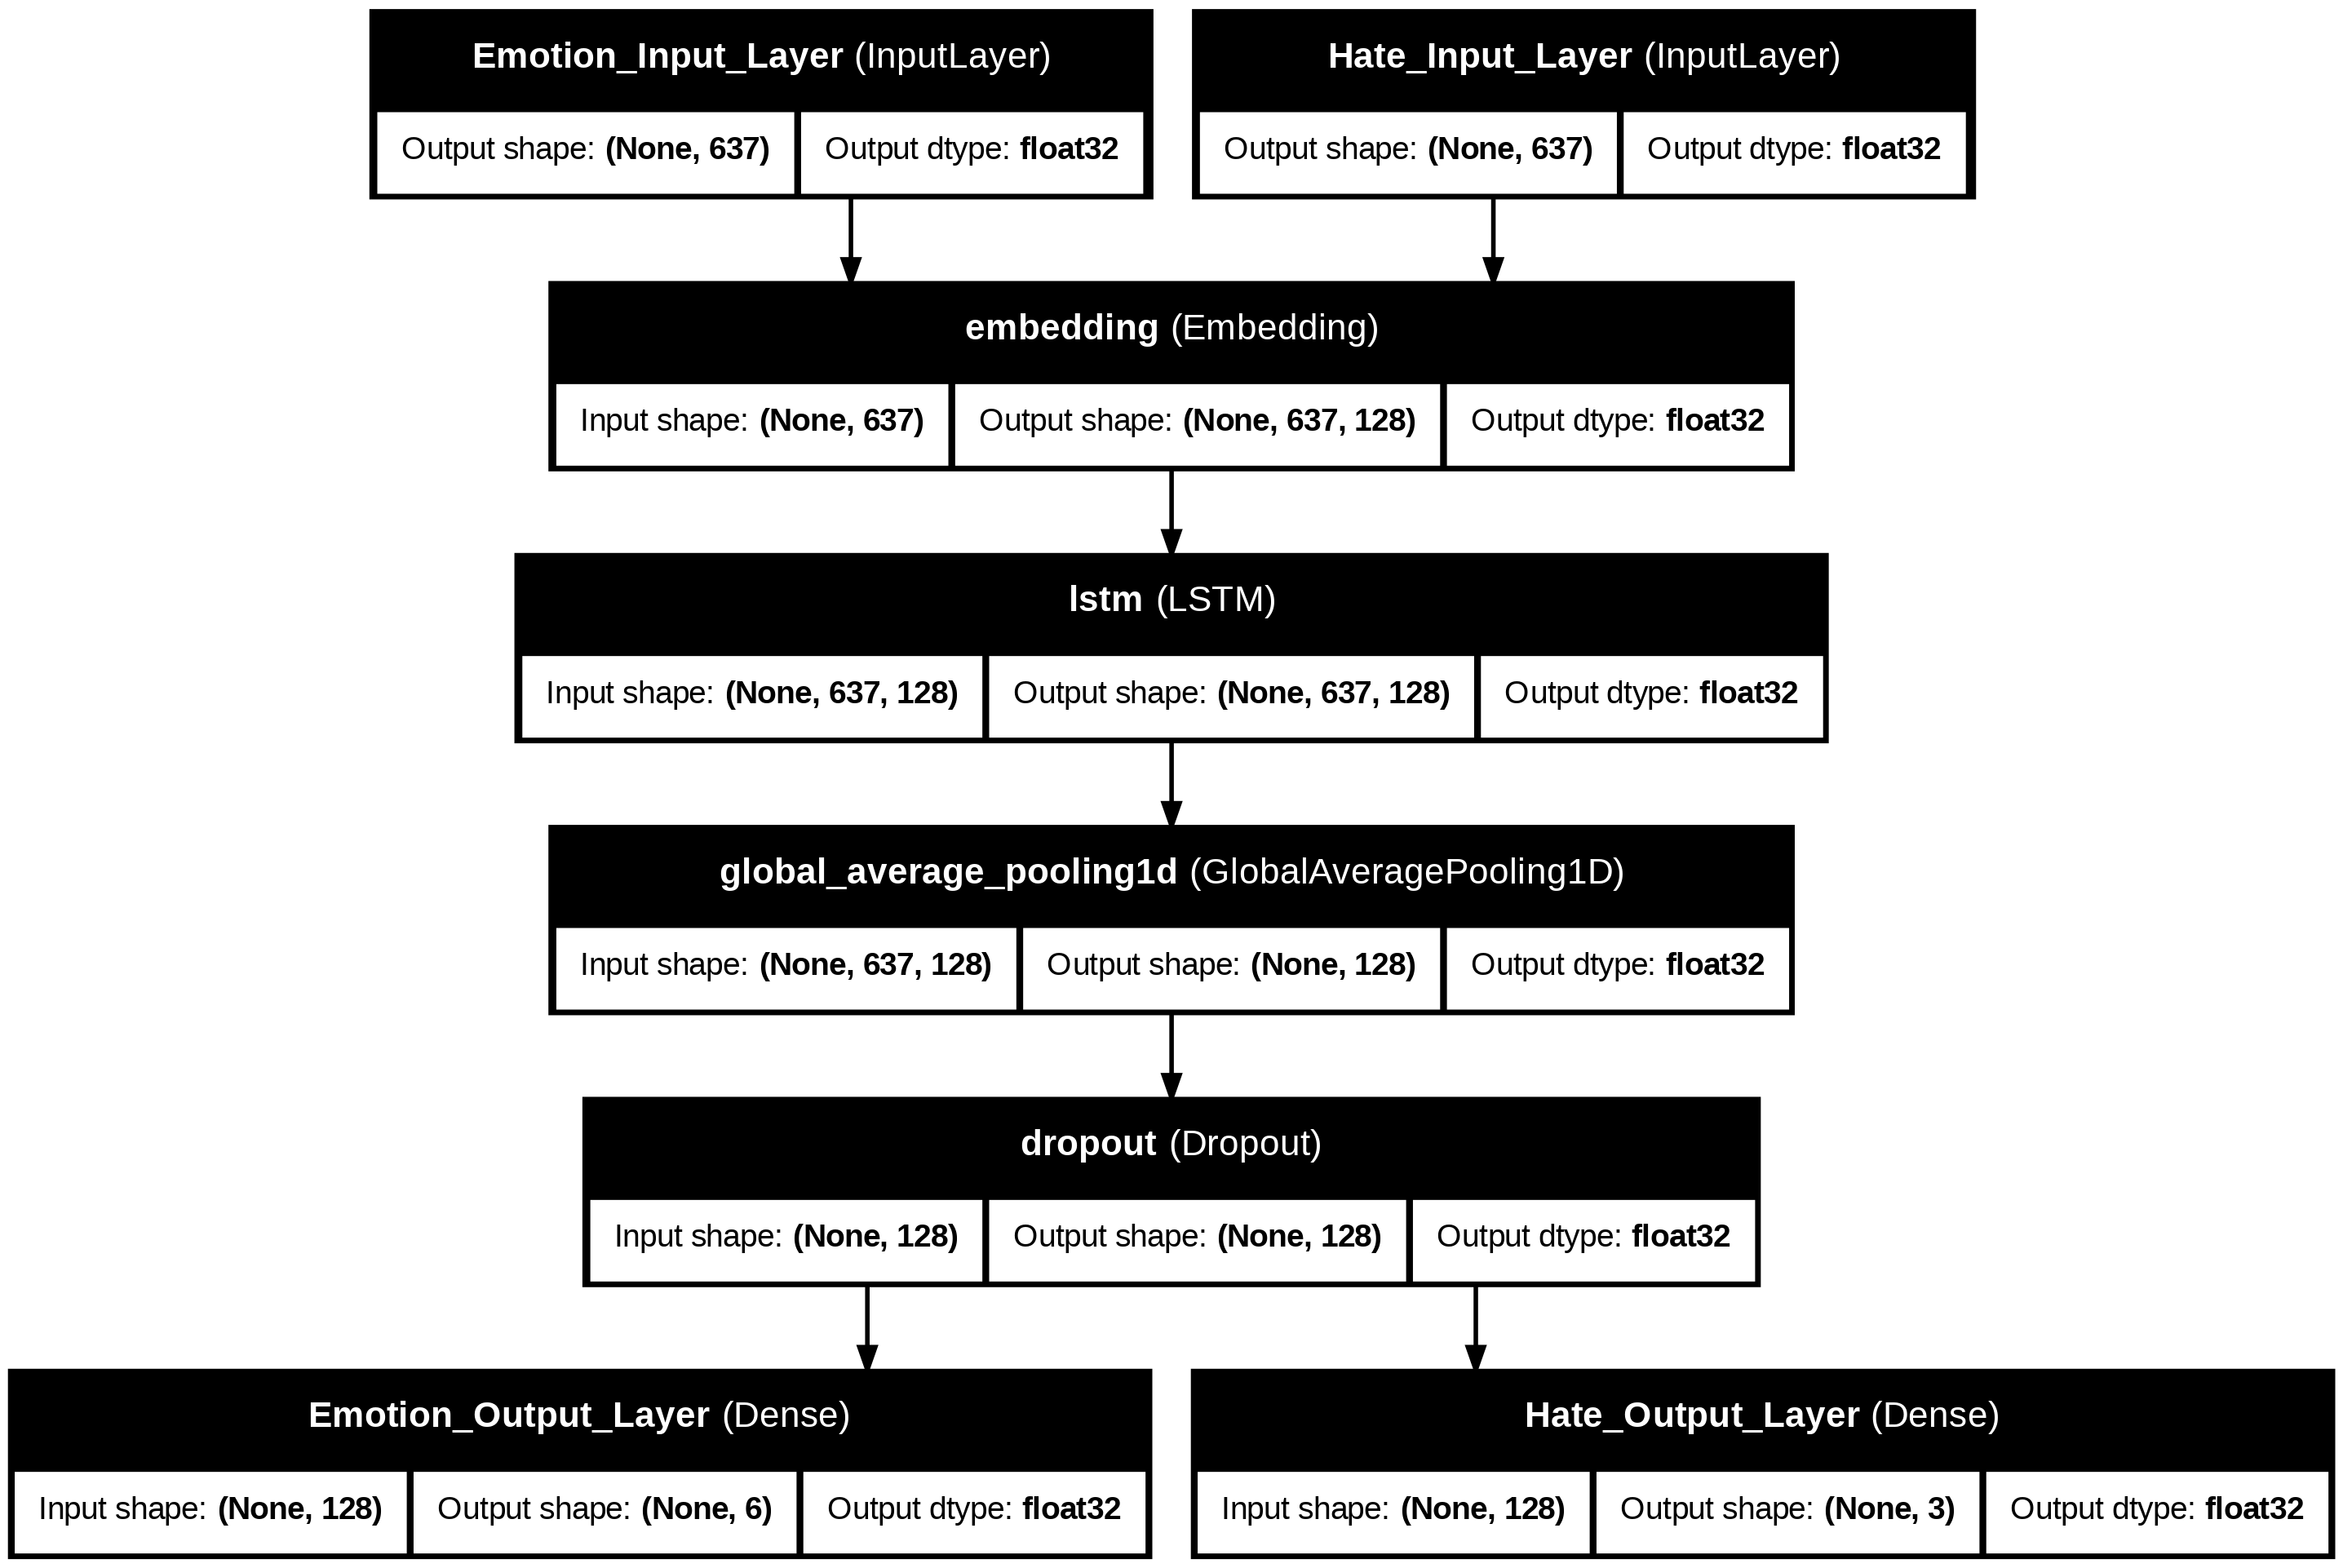

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True)

In [32]:
emotion_labels=emotion_['label'].astype(int).values
hate_labels=hate_['label'].astype(int).values

In [33]:
hate_labels

array([1, 1, 1, ..., 0, 2, 2])

In [35]:
## Training the model

model.fit(x={'Emotion_Input_Layer':padded_emotion,'Hate_Input_Layer':padded_hate},
          y={'Emotion_Output_Layer':emotion_labels,'Hate_Output_Layer':hate_labels},
          epochs=15,
          batch_size=5)

Epoch 1/15
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 131s 54ms/step - Emotion_Output_Layer_accuracy: 0.9908 - Emotion_Output_Layer_loss: 0.0246 - Hate_Output_Layer_accuracy: 0.9980 - Hate_Output_Layer_loss: 0.0067 - loss: 0.0313
Epoch 2/15
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 129s 54ms/step - Emotion_Output_Layer_accuracy: 0.9932 - Emotion_Output_Layer_loss: 0.0169 - Hate_Output_Layer_accuracy: 0.9985 - Hate_Output_Layer_loss: 0.0048 - loss: 0.0217
Epoch 3/15
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 156s 60ms/step - Emotion_Output_Layer_accuracy: 0.9919 - Emotion_Output_Layer_loss: 0.0213 - Hate_Output_Layer_accuracy: 0.9989 - Hate_Output_Layer_loss: 0.0038 - loss: 0.0251
Epoch 4/15
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 125s 52ms/step - Emotion_Output_Layer_accuracy: 0.9923 - Emotion_Output_Layer_loss: 0.0220 - Hate_Output_Layer_accuracy: 0.9987 - Hate_Output_Layer_loss: 0.0047 - loss: 0.0268
Epoch 5/15
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 110s 46ms/step - Emotion_Output_Layer_accuracy: 0.9939 - Emotion_Output_Layer_loss: 0.

Predictions

In [36]:
preds=model.predict({'Emotion_Input_Layer':padded_emotion,"Hate_Input_Layer":padded_hate})

emo_preds=np.argmax(preds[0],axis=1)
hate_preds=np.argmax(preds[1],axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


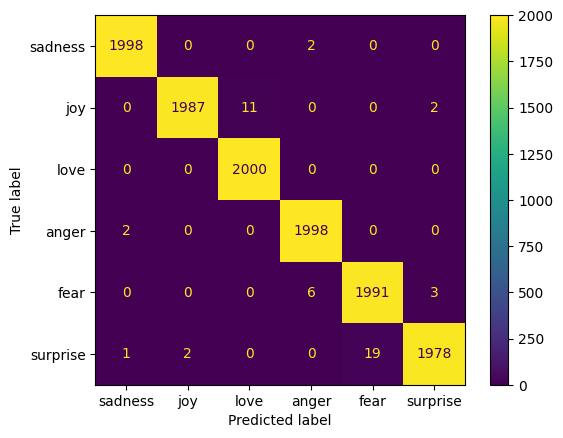

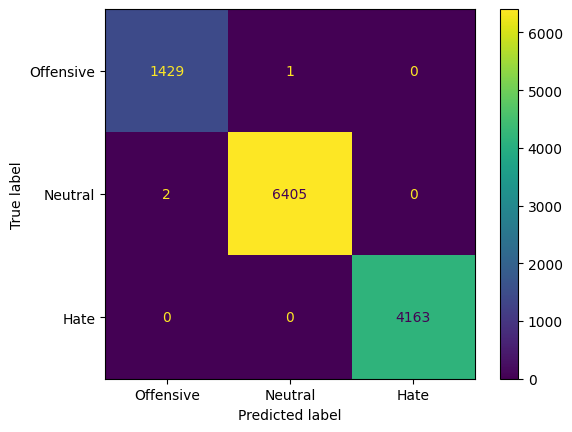

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_emotion=confusion_matrix(emotion_labels,emo_preds)
cm_hate=confusion_matrix(hate_labels,hate_preds)

disp1=ConfusionMatrixDisplay(confusion_matrix=cm_emotion,display_labels=['sadness','joy','love','anger','fear','surprise'])
disp2=ConfusionMatrixDisplay(confusion_matrix=cm_hate,display_labels=['Offensive','Neutral','Hate'])

disp1.plot()
disp2.plot()

In [63]:
def pipeline(text):
  text=clean_text(text)
  text=remove_stopwords(text)

  tokenized_text=tokenizer.texts_to_sequences([text])
  padded_text=pad_sequences(tokenized_text,maxlen=637,padding='post')

  preds=model.predict({'Emotion_Input_Layer':padded_text,'Hate_Input_Layer':padded_text})

  emo_preds=np.argmax(preds[0],axis=1)[0]
  hate_preds=np.argmax(preds[1],axis=1)[0]

  emotion_labels = ['sadness','joy','love','anger','fear','surprise']
  hate_labels = ['Offensive Speech','Neither','Hate Speech']

  emotion=emotion_labels[emo_preds]
  hate=hate_labels[hate_preds]

  return emotion,hate

In [59]:
model.save('multi_task-emotion-hate.h5')

In [70]:
pipeline('!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


('anger', 'Neither')

In [69]:
hate['text'].iloc[1]

'!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'